In [88]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, SpatialDropout2D
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# Suppress extra logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# 1️⃣ Dataset

data_dir = "/home/yutharsan/Desktop/EN3150-Assignment-03-DeepMind/datasets/realwaste-main/RealWaste"
img_size = (128, 128)
batch_size = 32

dataset = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)


Found 4752 files belonging to 9 classes.


In [89]:
# 2️⃣ Split dataset (70/15/15)

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

train_ds = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [90]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

In [ ]:
# 3️⃣ Improved CNN Model

model = keras.Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    SpatialDropout2D(0.1),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    SpatialDropout2D(0.1),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    SpatialDropout2D(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(dataset.class_names), activation='softmax')
])

model.summary()


/home/yutharsan/anaconda3/envs/tf_gpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_17            │ (None, 30, 30, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_18            │ (None, 14, 14, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_19            │ (None, 6, 6, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,114,057 (19.51 MB)

 Trainable params: 5,113,097 (19.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [92]:
# 4️⃣ Compile

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# 5️⃣ Callbacks

#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-8)


In [93]:

# 6️⃣ Train (100 epochs)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ reduce_lr]
)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.3501 - loss: 3.3024 - val_accuracy: 0.0966 - val_loss: 6.4949 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4721 - loss: 1.6416 - val_accuracy: 0.2273 - val_loss: 2.7586 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5057 - loss: 1.4294 - val_accuracy: 0.4389 - val_loss: 1.7832 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5415 - loss: 1.3425 - val_accuracy: 0.5312 - val_loss: 1.3085 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5718 - loss: 1.2277 - val_accuracy: 0.5185 - val_loss: 1.3949 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6082 - loss: 1.1247 - val_accuracy: 0.3722 - val_loss: 2.3386 - learning_rate: 0.0010
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6590 - loss: 0

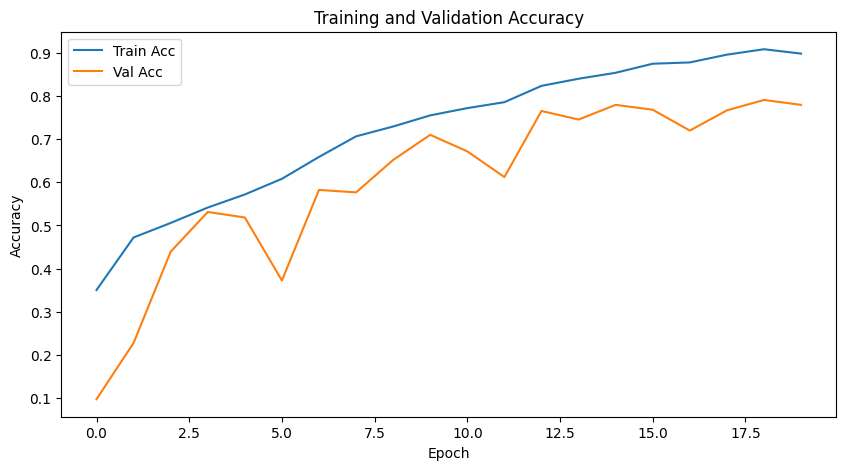

In [94]:
# 7️⃣ Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


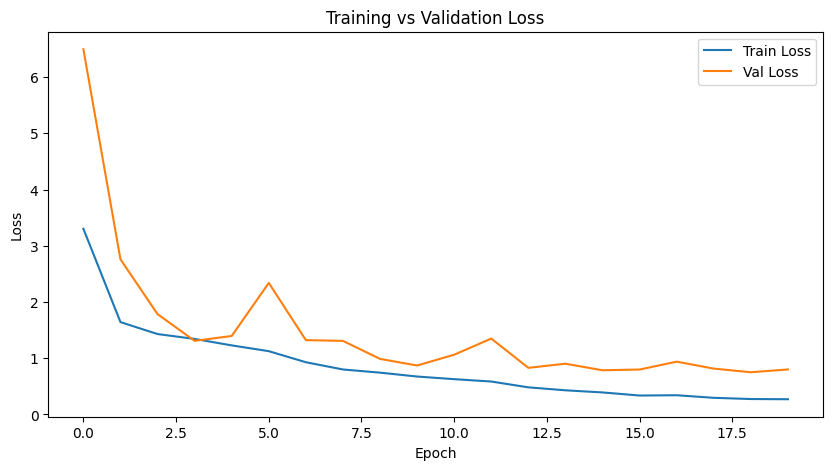

In [95]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [96]:
# 8️⃣ Evaluate

test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=dataset.class_names))


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7347 - loss: 0.8926
✅ Test Accuracy: 0.7347
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
                     precision    recall  f1-score   support

          Cardboard       0.70      0.75      0.72        71
      Food Organics       0.75      0.77      0.76        60
              Glass       0.85      0.77      0.81        52
              Metal       0.80      0.69      0.74       127
Miscellaneous Trash       0.70      0.54      0.61        74
              Paper       0.76      0.64      0.70        70
            Plastic       0.63      0.83      0.72       143
      Textile Trash       0.71      0.59      0.64        49
         Vegetation       0.86      0.95      0.90        74

           accuracy                           0.73       720
          macro avg       0.75      0.72      0.73       720
       weighted avg       0.74      0.73      0.73       720

